# NLP Project: Topic Modeling (Part 4)

** We saw in Part 3 that the review categories used were very broad. It is quite possible that each category is made up of more fine grain topics. **

** In this notebook, we will take an un-supervised appoarch to perform LDA Topic Modeling.**

In [2]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

import graphlab as gl
gl.canvas.set_target('ipynb')
#gl.canvas.set_target('browser')

import pyLDAvis
import pyLDAvis.graphlab
pyLDAvis.enable_notebook()

# Reuse Constructed Modules From Word2Vec

In [4]:
from NLPutils import *
"""
The NLPutils file makes available the following functions and classes.

Func: 
    * load_json_from_file()
    * txt2sentences()
    * txt2words()
    * print_statistics()

Class:
    * TrainSentences
    * DeepTextAnalyzer
""";

# Load Sport Review Dataset

In [5]:
Sport = load_json_from_file('/Users/marvinbertin/Desktop/data/reviews_Sports_and_Outdoors.json')

PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/reviews_Sports_and_Outdoors.json
PROGRESS: Parsing completed. Parsed 100 lines in 0.92719 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Read 87647 lines. Lines per second: 47060.3
PROGRESS: Read 515426 lines. Lines per second: 68720.3
PROGRESS: Read 943198 lines. Lines per second: 70881.9
PROGRESS: Read 1370102 lines. Lines per second: 71479.8
PROGRESS: Read 1798779 lines. Lines per second: 68365.9
PROGRESS: Read 2065606 lines. Lines per second: 64990.7
PROGRESS: Read 2332828 lines. Lines per second: 61819.8
PROGRESS: Read 2606295 lines. Lines per second: 60954.6
PROGRESS: Read 2890047 lines. Lines per second: 60539.2
PROGRESS: Finishe

In [96]:
# Take subset to make training faster
Sport_sub = Sport[:100000]

# Combine All the Reviews into One File

In [ ]:
BASE_DIR = "/Users/marvinbertin/Desktop/data"

mashed = "\n".join(Sport_sub['reviewText'])
filename = "TM_SportReviews.txt"
with open(os.path.join(BASE_DIR, "txt" , filename), "w") as f:
    f.write(mashed)

# Visualize Data

In [8]:
#  filter the paragraph that have less than 25 words.
Sport_sub.show()

# Count Number of Words per Reviews

In [97]:
Sport_sub = Sport_sub[['asin', 'reviewText']]

In [99]:
Sport_sub['reviewLength'] = Sport_sub['reviewText'].apply(lambda r: len(txt2words(r)))

In [100]:
Sport_sub

asin,reviewText,reviewLength
0000031852,Tutus are cute but alittle thin. Can't ...,14
0000031852,I origonally didn't getthe item I ordered. ...,32
0000031852,"Arrived very timely, cutegrandbaby loves it. Only ...",10
0000031852,My little girl just lovesto wear this tutu bec ...,24
0000031852,I bought this for my 3 yrold daughter when I took ...,23
0000031852,Bought it for a ballettutu but it is being ...,11
0000031852,My daughter and herfriends love the colors ...,11
0000031895,very cute and went greatwith my Halloween ...,20
0000031895,This tutu is completelysee-through. I bought it ...,16
0000031895,It was as described andfit my 6 year old grand ...,18


# Visualize Review Size Distribution

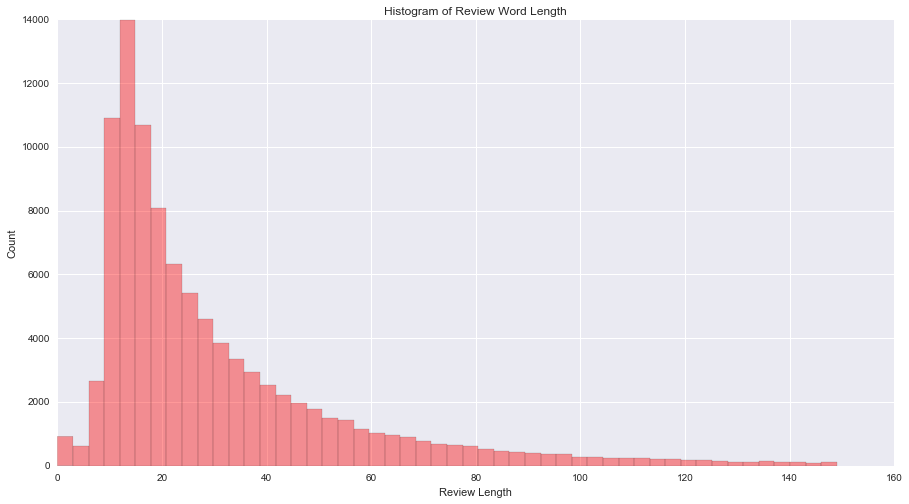

In [107]:
# Get rid of long tail to make histogram more readable
plt.figure(figsize=(15, 8))
sf = Sport_sub[Sport_sub['reviewLength'] < 150]
sns.distplot(sf['reviewLength'], kde = False, color = 'red', norm_hist=False)

plt.ylabel("Count")
plt.xlabel("Review Length")
plt.title("Histogram of Review Word Length");

# Remove Short Reviews for Richer Documents

In [108]:
Sport_sub = Sport_sub[Sport_sub['reviewLength'] >= 25]

In [109]:
Sport_sub

asin,reviewText,reviewLength
0000031852,I origonally didn't getthe item I ordered. ...,32
0000031909,"It's a really nice tutu,but there was one pro ...",28
0000032050,I wanted somethingdifferent to set us a ...,50
0000032069,"Poor quality, I guess youget what you paid for. I ...",30
0000032069,My daughter wanted tochange her wardrobe and ...,49
0188477284,I bought 2 of thesebottles for my nephew ...,57
059445039X,This was a gift for mygranddaughter. The bag ...,38
060791548X,"The map has no compassrose, North or ...",34
0615302939,I am the parent of a 13yr old junior golfer & ...,69
0615302939,Journey to Excellence byHenry Brunton with ...,89


# Feature Engineering
## Common Phrase Detector
* Detect phrases, based on collected **collocation counts**.
* **Adjacent words** that appear together more **frequently** than expected are **joined together** with the _ character.
* For example, after training some corpus specific phrases will be combined into **bigram or trigrams ('new_york' 'machine_learning')**.

# Train Bigrams and Trigrams on Full Text Reviews Saved Earlier

In [89]:
from gensim.models.phrases import Phrases

sentences = TrainSentences(os.path.join(BASE_DIR, "txt" , filename))
bigram = Phrases(sentences)
trigram = Phrases(bigram[sentences])

# Parse Common Phrases into Reviews

In [90]:
def PhraseParser(text):    
    return [w for w in trigram[bigram[text]]]

In [112]:
Sport_sub['processedReviews'] = Sport_sub['reviewText'].apply(txt2words)
Sport_sub['processedReviews'] = Sport_sub['processedReviews'].apply(PhraseParser)

In [113]:
Sport_sub

asin,reviewText,reviewLength,processedReviews
0000031852,I origonally didn't getthe item I ordered. ...,32,"[origonally, didn, get,item, ordered, ..."
0000031909,"It's a really nice tutu,but there was one pro ...",28,"[really, nice, tutu, one,problem, need, address, ..."
0000032050,I wanted somethingdifferent to set us a ...,50,"[wanted_something,different, set, us, ..."
0000032069,"Poor quality, I guess youget what you paid for. I ...",30,"[poor_quality, guess,get, paid, bought, k, ..."
0000032069,My daughter wanted tochange her wardrobe and ...,49,"[daughter, wanted,change, wardrobe, one, ..."
0188477284,I bought 2 of thesebottles for my nephew ...,57,"[bought, bottles,nephews, take, school, ..."
059445039X,This was a gift for mygranddaughter. The bag ...,38,"[gift, granddaughter,bag, beautiful, quality, ..."
060791548X,"The map has no compassrose, North or ...",34,"[map, compass_rose,north, declination, ..."
0615302939,I am the parent of a 13yr old junior golfer & ...,69,"[parent, yr_old, junior,golfer, journey, ..."
0615302939,Journey to Excellence byHenry Brunton with ...,89,"[journey, excellence,henry_brunton, michael, ..."


# Build Bag-of-Word Model with New Word Features

In [117]:
Sport_sub['processedReviews'] = Sport_sub['processedReviews'].apply(lambda w: " ".join(w))
Sport_sub['Unigram'] =  gl.text_analytics.count_ngrams(Sport_sub['processedReviews'], n=1)

In [118]:
Sport_sub

asin,reviewText,reviewLength,processedReviews,Unigram
0000031852,I origonally didn't getthe item I ordered. ...,32,origonally didn get itemordered contacting ...,"{'ordered': 3, 'turned':1, 'back': 1, 'wasn': 1, ..."
0000031909,"It's a really nice tutu,but there was one pro ...",28,really nice tutu oneproblem need address ...,"{'shrinks': 1, 'rip': 1,'one': 3, 'wash': 1, ..."
0000032050,I wanted somethingdifferent to set us a ...,50,wanted_somethingdifferent set us aside ...,"{'enjoy': 1, 'walking':1, 'set': 1, 'ordered': ..."
0000032069,"Poor quality, I guess youget what you paid for. I ...",30,poor_quality guess getpaid bought k race ...,"{'hoping': 1, 'mine': 1,'high': 1, 'quality': 2, ..."
0000032069,My daughter wanted tochange her wardrobe and ...,49,daughter wanted changewardrobe one big item ...,"{'fluffs': 1, 'right': 1,'begged': 1, 'bum': 1, ..."
0188477284,I bought 2 of thesebottles for my nephew ...,57,bought bottles nephewstake school however d ...,"{'carefully': 1,'laying': 1, 'ages': 1, ..."
059445039X,This was a gift for mygranddaughter. The bag ...,38,gift granddaughter bagbeautiful quality ...,"{'beautiful': 1, 'ad': 1,'product': 1, 'need': 1, ..."
060791548X,"The map has no compassrose, North or ...",34,map compass_rose northdeclination indication ...,"{'guessing': 1, 'lines':1, 'magnetic': 1, 'one': ..."
0615302939,I am the parent of a 13yr old junior golfer & ...,69,parent yr_old juniorgolfer journey excell ...,"{'henry': 1, 'golf': 3,'help': 1, 'figure': 1, ..."
0615302939,Journey to Excellence byHenry Brunton with ...,89,journey excellencehenry_brunton michael ...,"{'walking': 1, 'henry':3, 'golf': 2, 'mental': ..."


# Build LDA Topic Model (20 topics)

In [119]:
topic_model_20 = gl.topic_model.create(Sport_sub['Unigram'], num_topics=20, num_iterations=200)

PROGRESS: Learning a topic model
PROGRESS:        Number of documents     43891
PROGRESS:            Vocabulary size     53222
PROGRESS:    Running collapsed Gibbs sampling
PROGRESS: +-----------+---------------+----------------+-----------------+
PROGRESS: | Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |
PROGRESS: +-----------+---------------+----------------+-----------------+
PROGRESS: | 10        | 4.60s         | 4.96511e+06    | 0               |
PROGRESS: | 20        | 8.31s         | 5.73648e+06    | 0               |
PROGRESS: | 30        | 15.89s        | 3.22314e+06    | 0               |
PROGRESS: | 40        | 22.48s        | 3.64643e+06    | 0               |
PROGRESS: | 50        | 27.33s        | 5.1352e+06     | 0               |
PROGRESS: | 60        | 32.80s        | 3.72857e+06    | 0               |
PROGRESS: | 70        | 38.76s        | 3.64504e+06    | 0               |
PROGRESS: | 80        | 42.86s        | 5.64426e+06    | 0               |
PR

# Top 5 Most Relevant Words for Each Topic

In [120]:
topic_model_20.get_topics().print_rows(100)

+-------+-------------+------------------+
| topic |     word    |      score       |
+-------+-------------+------------------+
|   0   |     bag     | 0.0233492535797  |
|   0   |     good    | 0.0197370301331  |
|   0   |   plastic   | 0.0176967193072  |
|   0   |     well    | 0.0141638853869  |
|   0   |    little   | 0.0129333477293  |
|   1   |    knife    | 0.0493250063613  |
|   1   |     one     | 0.0229781647667  |
|   1   |    blade    | 0.0191893645161  |
|   1   |    pocket   |  0.015771055803  |
|   1   |     tool    | 0.0157081421457  |
|   2   |    watch    | 0.0221292966339  |
|   2   |     use     | 0.0163653385083  |
|   2   |     time    | 0.0137912156388  |
|   2   |    water    | 0.0114989851873  |
|   2   |     keep    | 0.00931802805869 |
|   3   |     one     | 0.0175767977696  |
|   3   |     like    | 0.0141155792937  |
|   3   |     best    | 0.0124087857792  |
|   3   |     quot    | 0.0096541004325  |
|   3   |    great    | 0.00963028470904 |
|   4   |  

# Visualize Topic Clusters and Word Relevance

In [121]:
pyLDAvis.graphlab.prepare(topic_model_20, Sport_sub['Unigram'])

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      5.339387        1       1 -0.114826  0.003551
12     5.331427        1       2 -0.123688 -0.034374
18     5.306682        1       3  0.232718 -0.072499
17     5.298344        1       4 -0.105959  0.041347
5      5.229885        1       5 -0.227080  0.027544
11     5.143801        1       6  0.092928  0.147618
19     5.106831        1       7  0.104733  0.019625
2      5.086379        1       8 -0.137649  0.120719
4      5.037924        1       9  0.134460  0.238357
3      4.983612        1      10  0.122198  0.055607
14     4.972428        1      11 -0.073116  0.036125
9      4.907607        1      12  0.089513 -0.047917
10     4.904949        1      13 -0.009495  0.041097
13     4.854305        1      14  0.017980  0.125058
15     4.788098        1      15 -0.131175 -0.176487
7      4.772608        1      16 -0.137664  0.047225
0      4.771041        1      17 -0.015106 -0.206612
8      4.725313        1      18  0.168600 -0.062312
6      4.720217        1      19  0.099688 -0.168304
16     4.719162        1      20  0.012942 -0.135368, topic_info=      Category          Freq         Term  Total  loglift  logprob
8039   Default   7056.000000        knife   7056  30.0000  30.0000
1159   Default  25070.000000          one  25070  29.0000  29.0000
4291   Default  11182.000000      product  11182  28.0000  28.0000
16374  Default   6981.000000        years   6981  27.0000  27.0000
40561  Default   6292.000000          old   6292  26.0000  26.0000
52061  Default  19590.000000          use  19590  25.0000  25.0000
31187  Default   6402.000000        price   6402  24.0000  24.0000
287    Default   5592.000000         size   5592  23.0000  23.0000
45972  Default   6343.000000      quality   6343  22.0000  22.0000
33060  Default  13945.000000         well  13945  21.0000  21.0000
42472  Default  16689.000000        great  16689  20.0000  20.0000
29875  Default   5175.000000         year   5175  19.0000  19.0000
12819  Default   9709.000000       bought   9709  18.0000  18.0000
52903  Default   4133.000000       amazon   4133  17.0000  17.0000
48423  Default  14295.000000         good  14295  16.0000  16.0000
34295  Default   3924.000000          mat   3924  15.0000  15.0000
7782   Default  14954.000000          get  14954  14.0000  14.0000
16331  Default   3776.000000         ball   3776  13.0000  13.0000
232    Default   5354.000000          fit   5354  12.0000  12.0000
32255  Default   3516.000000         game   3516  11.0000  11.0000
7239   Default  16416.000000        would  16416  10.0000  10.0000
23903  Default   3512.000000        bands   3512   9.0000   9.0000
9628   Default  16743.000000         like  16743   8.0000   8.0000
31604  Default  11335.000000         time  11335   7.0000   7.0000
29981  Default   4261.000000         bike   4261   6.0000   6.0000
29714  Default   8325.000000           ve   8325   5.0000   5.0000
18822  Default  10665.000000         used  10665   4.0000   4.0000
33680  Default   8290.000000            m   8290   3.0000   3.0000
37103  Default   3045.000000         wear   3045   2.0000   2.0000
4363   Default   2984.000000          son   2984   1.0000   1.0000
...        ...           ...          ...    ...      ...      ...
287    Topic20   4678.125773         size   5592   2.8290  -3.2966
52899  Topic20    481.099012        pants    526   2.9215  -5.5678
32636  Topic20    510.320602       winter    573   2.8961  -5.5076
20612  Topic20   1539.587692         pair   1915   2.7926  -4.4046
53193  Topic20    377.330590         boot    446   2.8440  -5.8103
30504  Topic20   1691.489920  comfortable   2607   2.5773  -4.3114
232    Topic20   2680.764798          fit   5354   2.3164  -3.8526
47948  Topic20    673.200696      running    983   2.6338  -5.2303
10078  Topic20   1199.912357        large   2589   2.2427  -4.6529
33397  Topic20    605.161137         warm   

# Build LDA Topic Model (5 topics)

In [122]:
topic_model_5 = gl.topic_model.create(Sport_sub['Unigram'], num_topics=5, num_iterations=200)
pyLDAvis.graphlab.prepare(topic_model_5, Sport_sub['Unigram'])

PROGRESS: Learning a topic model
PROGRESS:        Number of documents     43891
PROGRESS:            Vocabulary size     53222
PROGRESS:    Running collapsed Gibbs sampling
PROGRESS: +-----------+---------------+----------------+-----------------+
PROGRESS: | Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |
PROGRESS: +-----------+---------------+----------------+-----------------+
PROGRESS: | 10        | 3.05s         | 7.82903e+06    | 0               |
PROGRESS: | 20        | 6.41s         | 7.19703e+06    | 0               |
PROGRESS: | 30        | 9.41s         | 7.05617e+06    | 0               |
PROGRESS: | 40        | 13.48s        | 5.51384e+06    | 0               |
PROGRESS: | 50        | 16.74s        | 7.38844e+06    | 0               |
PROGRESS: | 60        | 20.12s        | 5.77453e+06    | 0               |
PROGRESS: | 70        | 23.87s        | 7.7215e+06     | 0               |
PROGRESS: | 80        | 27.65s        | 5.15436e+06    | 0               |
PR

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      20.617776        1       1 -0.075538 -0.017518
3      20.499261        1       2 -0.134913  0.016845
2      19.766232        1       3 -0.160254 -0.041861
0      19.575685        1       4  0.214822 -0.210202
1      19.541047        1       5  0.155882  0.252736, topic_info=      Category          Freq     Term  Total  loglift  logprob
4291   Default  11182.000000  product  11182  30.0000  30.0000
52061  Default  19590.000000      use  19590  29.0000  29.0000
8039   Default   7056.000000    knife   7056  28.0000  28.0000
40561  Default   6292.000000      old   6292  27.0000  27.0000
29875  Default   5175.000000     year   5175  26.0000  26.0000
1159   Default  25070.000000      one  25070  25.0000  25.0000
18822  Default  10665.000000     used  10665  24.0000  24.0000
50759  Default   4384.000000    water   4384  23.0000  23.0000
29981  Default   4261.000000     bike   4261  22.0000  22.0000
29415  Default   6076.000000      put   6076  21.0000  21.0000
52903  Default   4133.000000   amazon   4133  20.0000  20.0000
1732   Default   5980.000000    small   5980  19.0000  19.0000
12819  Default   9709.000000   bought   9709  18.0000  18.0000
16331  Default   3776.000000     ball   3776  17.0000  17.0000
9628   Default  16743.000000     like  16743  16.0000  16.0000
45972  Default   6343.000000  quality   6343  15.0000  15.0000
23903  Default   3512.000000    bands   3512  14.0000  14.0000
34295  Default   3924.000000      mat   3924  13.0000  13.0000
32255  Default   3516.000000     game   3516  12.0000  12.0000
46497  Default   6915.000000    using   6915  11.0000  11.0000
22270  Default   7676.000000     back   7676  10.0000  10.0000
40527  Default   7796.000000     easy   7796   9.0000   9.0000
28057  Default   5688.000000   around   5688   8.0000   8.0000
37103  Default   3045.000000     wear   3045   7.0000   7.0000
7239   Default  16416.000000    would  16416   6.0000   6.0000
4363   Default   2984.000000      son   2984   5.0000   5.0000
39274  Default   4258.000000    light   4258   4.0000   4.0000
37043  Default   2991.000000    watch   2991   3.0000   3.0000
34157  Default   2864.000000     item   2864   2.0000   2.0000
7782   Default  14954.000000      get  14954   1.0000   1.0000
...        ...           ...      ...    ...      ...      ...
32206   Topic5    810.592470    older    812   1.6138  -6.4413
19975   Topic5    762.596617      net    763   1.6151  -6.5023
17846   Topic5   1305.510348  husband   1324   1.6013  -5.9649
25978   Topic5   1058.533191   straps   1074   1.6010  -6.1745
1439    Topic5    960.546050   wheels    972   1.6037  -6.2716
29415   Topic5   4908.776067      put   6076   1.4027  -4.6398
18346   Topic5   1224.343895    broke   1286   1.5664  -6.0289
28057   Topic5   4035.643742   around   5688   1.2739  -4.8347
51693   Topic5   1323.053675    stick   1448   1.5255  -5.9512
40527   Topic5   4935.843957     easy   7796   1.1608  -4.6325
22270   Topic5   4581.394978     back   7676   1.1027  -4.7061
12819   Topic5   5262.819410   bought   9709   1.0049  -4.5689
32275   Topic5   4051.261473      two   7144   1.0516  -4.8290
1159    Topic5   9207.352468      one  25070   0.6209  -4.0043
23545   Topic5   3741.772873      got   6783   1.0252  -4.9072
9588    Topic5   1358.620079    front   1545   1.4875  -5.9244
46037   Topic5   2026.919520     able   3020   1.2188  -5.5228
7839    Topic5   2833.111107   enough   5427   0.9685  -5.1870
34454   Topic5   3749.990402   little   9702   0.6695  -4.9051
7239    Topic5   4637.674911    would  16416   0.3555  -4.6931
7782    Topic5   4265.629805      get  14954   0.3705  -4.7714
232     Topic5   2490.152194      fit   5354   0.8526  -5.3164
48438   Topic5   1971.387464   easily   3462   1.0547  -5.5503
42472   Topic5   3841.800147    great  16689   0.1535  -4.8786
7652    Topic5   2715.078515    first   7631   0.59

# Automatic Review Summarization (with Weighted Undirected Graphs)
## TextRank – a graph-based ranking model for text processing
* This module **automatically summarizes** the given text, by extracting one or more **important sentences** from the text.
* It can also extract **keywords**.
* This summarizer is based on the **"TextRank" algorithm**, from an [article](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf) by Mihalcea et al. 

## TextRank for Keyword Extraction

![](images/keywords.png)

## TextRank for Sentence Extraction

![](images/sentences.png)

# Review Summary Demonstration

In [123]:
from gensim.summarization import summarize, keywords

In [133]:
text = Sport_sub['reviewText'][11]
print "ORIGINAL REVIEW:\n", text

ORIGINAL REVIEW:
Twenty-five years ago when I was competing in junior golf tournaments all over the Midwest and struggling to improve I would have given anything for this book. I've worked in the golf publishing business for nearly 20 years and have never seen a step-by-step guide that explains how the best junior golfers continue to improve and reach their full potential until Journey to Excellence. It took someone of Henry Brunton's credentials to finally pull all the key information into one resource. Brunton is the Head Coach for the Canadian National Men's Team, he is the only Canadian ever named one of GOLF Magazine's Top 100 Teachers, he is the creator of the teaching curriculum used by the Canadian PGA and near Toronto he runs one of the finest regional junior programs in the world for competitive juniors. A program that has been emulated by instructors all over North America.Journey to Excellence details the intricacies of every major issue that a young competitive golfer will

In [139]:
print 'SUMMARY:'
print summarize(text)

[WARNING] Input text is expected to have at least 10 sentences.
[WARNING] Input corpus is expected to have at least 10 documents.


SUMMARY:
I've worked in the golf publishing business for nearly 20 years and have never seen a step-by-step guide that explains how the best junior golfers continue to improve and reach their full potential until Journey to Excellence.


In [140]:
print 'SUMMARY:'
print summarize(text, word_count=100)

[WARNING] Input text is expected to have at least 10 sentences.
[WARNING] Input corpus is expected to have at least 10 documents.


SUMMARY:
I've worked in the golf publishing business for nearly 20 years and have never seen a step-by-step guide that explains how the best junior golfers continue to improve and reach their full potential until Journey to Excellence.
From equipment issues, to finding the right coach, to managing emotions to understanding how to earn a college scholarship, it's all right here in a breezy read filled with anecdotes from the game's best players who have already reached their full potential in the game.Brunton saw the need for providing honest, accurate information to the next generation of competitive golfers and spent two years working on this manuscript.


In [141]:
print 'KEYWORDS:'
print keywords(text)

KEYWORDS:
coach
right
head
issues
major issue
read
brunton
equipment
force
information
honest accurate
scholarship


# Second Review

In [153]:
text = Sport_sub['reviewText'][184]
print "ORIGINAL REVIEW:\n", text
print 
print 'SUMMARY:'
print summarize(text, word_count=50)
print 
print 'KEYWORDS:'
print keywords(text)

ORIGINAL REVIEW:
My kid just turned nine and was very excited to get this for xmas.  I helped him get started putting it together for a few hours one evening (we took our time, separated the parts and had to deal with two other brothers harassing us and/or trying to play with it) and we agreed to finish it the next day.  Next morning, I came downstairs at 10am and he had finished it himself.  He loves playing with it and his younger brother (6 yrs old) loves it so much he started playing with it as soon as we had put in the foundation!  Yes, as far as building this toy, it is definitely more complicated than most, but that is what they love about it.  And I really enjoyed spending time with my boy putting it together.  If your kids like to build things like legos, I guarantee he/she will really enjoy this.  If not, most will still like it for the marble fun and all the neat moving parts.  I think it also gets my kids thinking in ways they normally would not, especially with video games

** what to note:**
* Keyword extraction performs well
* Summary performance varies, but works best on longer reviews

# PART 5: Convolutional Neural Networks for Sentence Classification
Yoon Kim's [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/pdf/1408.5882v2.pdf) 3 Sep 2014.